# REAP-seq protein acceleration analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import velocyto as vcy
%config InlineBackend.figure_format = 'retina'

In [2]:
import pa

Import protein count data. Acquired from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2685243, file **GSM2685243_protein_2_PBMCs_matrix.txt.gz**, processed into csv format.

In [3]:
[prot_count_array,prot_cells,adt_names] = pa.import_prot_data( \
    '/data/hoan/multiomics/sc_velocity/data/GSM2685243_protein_2_PBMCs_matrix_processed.csv')

Display proteins with available data. 

In [4]:
print(adt_names)

['CD335' 'CD33' 'CD11b' 'HLA-DRA' 'CD8' 'CD152' 'CD127' 'CD25' 'TIGIT'
 'CD45' 'CD66b' 'CD56' 'CD27' 'CD4' 'CD45RO' 'CD8a' 'CD68' 'CD223' 'FOXP3'
 'CD73' 'CD69' 'CD28' 'CD279' 'CD9' 'CD19' 'CD40' 'CD273' 'CD158E1' 'CD4'
 'CD154' 'CD3' 'CD20' 'CD274' 'CD137' 'CD357' 'CD45' 'CD45RA' 'CD155'
 'CD272' 'CD278' 'CD14' 'CD197' 'CD134' 'CD8']


Aligned bam file was acquired from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2685238, file **mRNA_2_PBMCs_possorted_genome_bam.bam**.

`velocyto` processing:
`velocyto run (BAM directory)/mRNA_2_PBMCs_possorted_genome_bam.bam (transcriptome directory)/genes/genes.gtf`



Import `velocyto` command-line interface (CLI) pipeline output.

In [5]:
vlm = vcy.VelocytoLoom("/data/hoan/multiomics/sc_velocity/data/mRNA_2_PBMCs_possorted_genome_bam_BJ2UE.loom")

Select 3000 genes with highest variability.

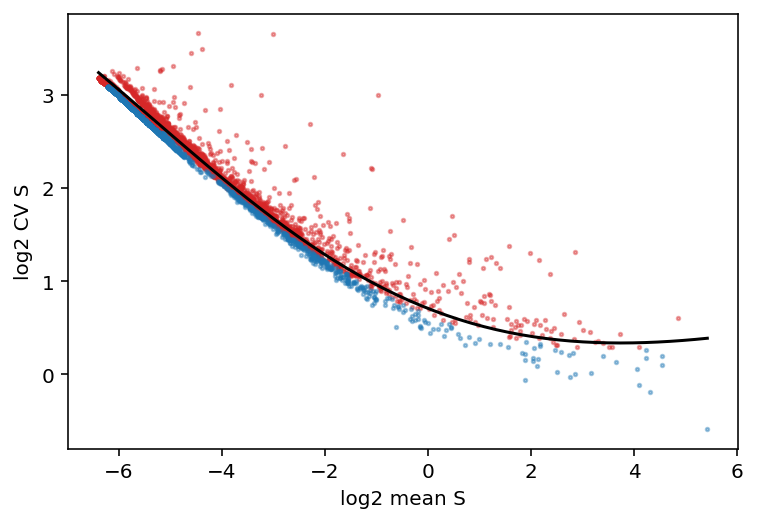

In [6]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)

Define relationship between proteins and source mRNA.

In [7]:
gene_dict = {'CD335':['NCR1'],
            'CD33':['CD33'],
            'CD11b':['ITGAM'],
            'HLA-DRA':['HLA-DRA'],
            'CD8':['CD8A','CD8B'],
            'CD152':['CTLA4'],
            'CD127':['IL7R'],
            'CD25':['IL2RA'],
            'TIGIT':['TIGIT'],
            'CD45':['PTPRC'],
            'CD66b':['CEACAM8'],
            'CD56':['NCAM1'],
            'CD27':['CD27'],
            'CD4':['CD4'],
            'CD45RO':['PTPRC'],
            'CD8a':['CD8A'],
            'CD68':['CD68'],
            'CD223':['LAG3'],
            'FOXP3':['FOXP3'],
            'CD73':['NT5E'],
            'CD69':['CD69'],
            'CD28':['CD28'],
            'CD279':['PDCD1'],
            'CD9':['CD9'],
            'CD19':['CD19'],
            'CD40':['CD40'],
            'CD273':['PDCD1LG2'],
            'CD158E1':['KIR3DL1'],
            'CD4':['CD4'],
            'CD154':['CD40LG'],
            'CD3':['CD3D','CD3E','CD3G'],
            'CD20':['MS4A1'],
            'CD274':['CD274'],
            'CD137':['TNFRSF9'],
            'CD357':['TNFRSF18'],
            'CD45':['PTPRC'],
            'CD45RA':['PTPRC'],
            'CD155':['PVR'],
            'CD272':['BTLA'],
            'CD278':['ICOS'],
            'CD14':['CD14'],
            'CD197':['CCR7'],
            'CD134':['TNFRSF4'],
            'CD8':['CD8A','CD8B']}

InvertDict = lambda d: dict( (v,k) for k in d for v in d[k] )



Define inverse relationship.

In [8]:
prot_dict = InvertDict(gene_dict)
mrna_targets = list(prot_dict.keys())

Append genes that yield observed proteins even if variability is relatively low for RNA velocity phase plots. Filter genes. Save ADT names.

In [9]:
pa.enforce_protein_filter(vlm,mrna_targets,adt_names)

In [10]:
vlm.filter_genes(by_cv_vs_mean=True,by_detection_levels=True)

Check format of intersection cell IDs. Filter for intersection of cell UMIs. 

In [11]:
vlm.ca['CellID'][0]

'mRNA_2_PBMCs_possorted_genome_bam_BJ2UE:AAACATACAGTGTC'

In [12]:
first_char = vlm.ca['CellID'][0].find(':')+1
last_char = 0

[prot_count_array, shared_cells, prot_cells] = pa.shared_cells_filter(vlm, prot_cells, prot_count_array, first_char, last_char)

ADT cell number: 3158
RNAseq cell number: 4273
Shared cells: 3158
Shared cells with more than 5 molecules: 3158


Perform knn imputation using protein space (more robust due to higher counts, less subject to the curse of dimensionality due to low number of quantified proteins vs. RNA).

In [13]:
pa.impute(vlm, prot_count_array, k=30, impute_in_prot_space=True, size_norm=False, impute_in_pca_space=False)

Find clusters in protein space in order to ID cell types.

In [14]:
t_cl = [0, 1, 2, 3, 1, 1, 2]
[cluster_ID, num_clusters] = pa.identify_clusters(vlm,vlm.connectivity,
                                                  correct_tags=True,tag_correction_list=t_cl,
                                                  method_name='RBERVertexPartition')

In [15]:
num_clusters

4

In [16]:
COLORS=np.asarray([[0, 0.4470, 0.7410], #CD4
                    [0.4940, 0.1840, 0.5560], #Mono                                        
                    [0.8500, 0.3250, 0.0980], #CD8
                    [0.9290, 0.6940, 0.1250] #B
                  ])
cluster_labels = ["CD4+ T", "Mono.", "CD8+ T", "B"]
# cluster_labels = ['CD4+ T','B','Mono.','CD8+ T']
vlm.COLORS = COLORS
vlm.labels=cluster_labels


Visualize clusters 

In [17]:
pa.fit_pcs(vlm,'P_norm','prot_pcs',n_pcs=10)
pa.fit_tsne(vlm, 'prot_pcs', 'prot_tsne', 10, seed=20)

<Figure size 1080x720 with 0 Axes>

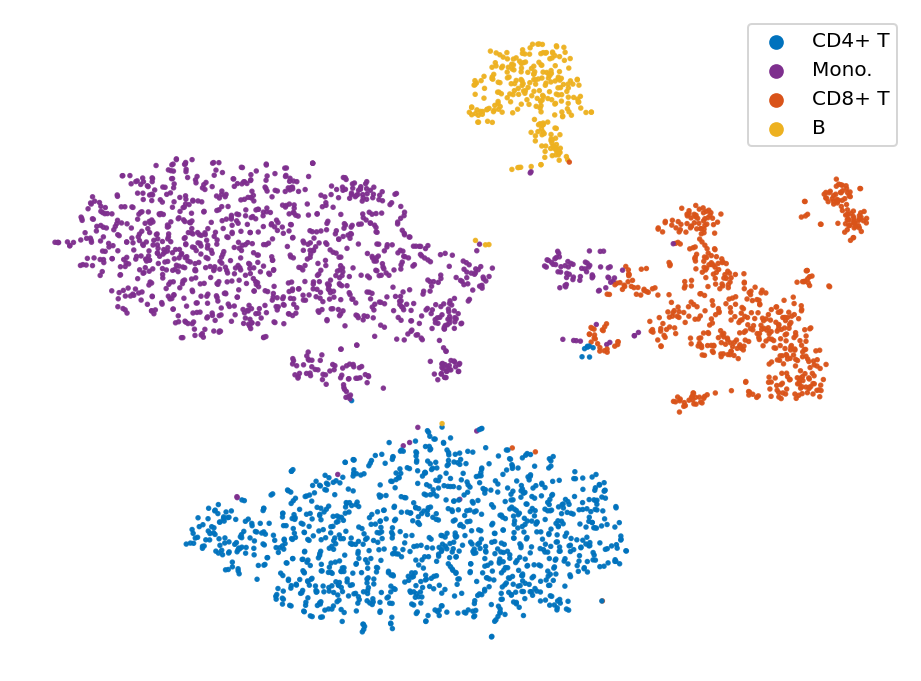

In [18]:
plt.figure(figsize=(15,10))
pa.visualize_pcs(vlm, [1,2], 'prot_tsne')

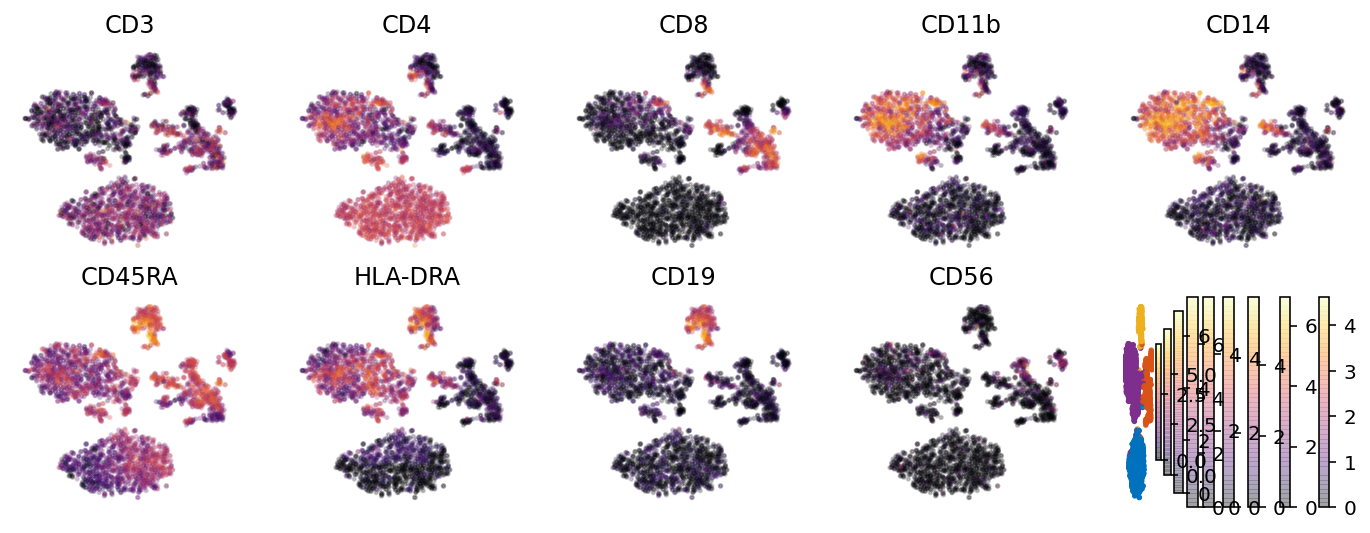

In [19]:
marker_list = ['CD3','CD4','CD8','CD11b','CD14','CD45RA','HLA-DRA','CD19','CD56']
# pa.visualize_protein_markers(vlm, protein_markers=marker_list, pc_targets=[2,3], visualize_clusters= True)
# plt.savefig("fig/reap_clus.svg")
from joint_velo import *
visualize_protein_markers_tsne(vlm, protein_markers=marker_list, pc_targets=[1,2], visualize_clusters= True)

Visualize protein phase portraits.

In [20]:
mrna_targets = list(set(mrna_targets).intersection(set(vlm.ra['Gene'])))

In [21]:
#pa.visualize_phase_portraits(vlm, mrna_targets, target='protein', imputed=True, prot_dict=prot_dict)

Manually select RNA/protein pairs with reasonably diagonal plots for protein velocity.

In [22]:
genes_used_for_prot_velocity = ['ITGAM','HLA-DRA','CD8A','CD8B','IL7R','PTPRC','CD28','PDCD1',
                                'CD27','CD9','CD19','CD40','CD3D','MS4A1','CD14','ICOS']

adt_used_for_prot_velocity = ['CD11b','HLA-DRA','CD8a','CD8','CD127','CD45RA','CD28','CD279',
                              'CD27','CD9','CD19','CD40','CD3','CD20','CD14','CD278']

Perform PCA embedding reduction in spliced space for embedding.

In [23]:
target_size_median = [np.median(vlm.S.sum(0)), np.median(vlm.U.sum(0))]
vlm.normalize(which="both",size=True,target_size=target_size_median)
pa.fit_pcs(vlm,'S_norm','pcs',3)

In [24]:
# pa.visualize_pcs(vlm, [1,2], pc_space='pcs')
# pa.visualize_pcs(vlm, [2,3], pc_space='pcs')

Fit degradation parameters; extrapolate.

In [25]:
pa.gamma_fit(vlm,'Sx','Ux','rna')
pa.extrapolate(vlm,vel_type='rna')

/home/vanhoan310/miniconda3/envs/tsne/lib/python3.7/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


In [26]:
pa.gamma_fit(vlm,'Px','Sx','protein',genes_used_for_prot_velocity, adt_used_for_prot_velocity)
pa.extrapolate(vlm,vel_type='protein')

Examine parameter fits.

In [27]:
n_rna_velo_fit_viz = 24
np.random.seed(1283989)
print(str(len(vlm.rna_velo_gene_ind))+' spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying '\
      +str(n_rna_velo_fit_viz)+' random phase portraits:')
genes_for_rna_velo_fit=np.random.choice(vlm.rna_velo_gene_ind,n_rna_velo_fit_viz,replace=False)

348 spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying 24 random phase portraits:


In [28]:
rna_vel_genes=vlm.ra['Gene'][genes_for_rna_velo_fit]
# pa.visualize_phase_portraits(vlm, rna_vel_genes, target='mrna', plot_fit=True)
# plt.savefig("fig/reap_rnaphase.svg")

In [29]:
# pa.visualize_phase_portraits(vlm, mrna_targets, target='protein', imputed=True, prot_dict=prot_dict, plot_fit=True)
# plt.savefig("fig/reap_protphase.svg")

Project velocity direction into the embedding using the transition matrix method.

In [30]:
pa.identify_embedding_knn(vlm,'pcs',[1,2])

In [31]:
pa.calculate_embedding_delta(vlm,'Sx','delta_S','delta_S_in_S_pca','rna_velo_gene_ind')

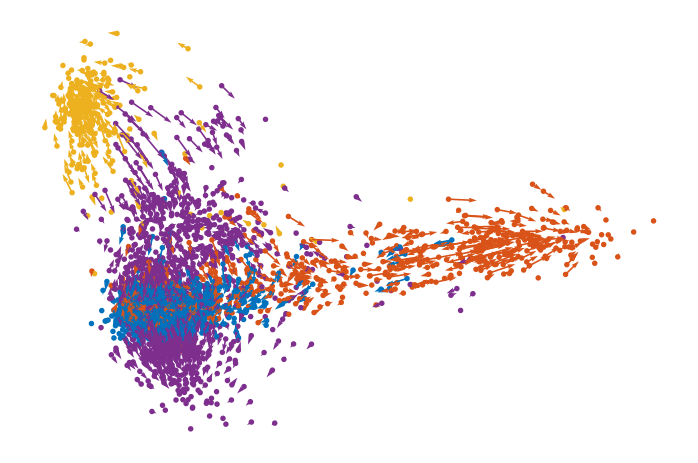

In [32]:
pa.visualize_velocity_projection(vlm, 'delta_S_in_S_pca')

In [33]:
pa.calculate_embedding_delta(vlm,'Px','delta_P','delta_P_in_S_pca','prot_velo_prot_ind')

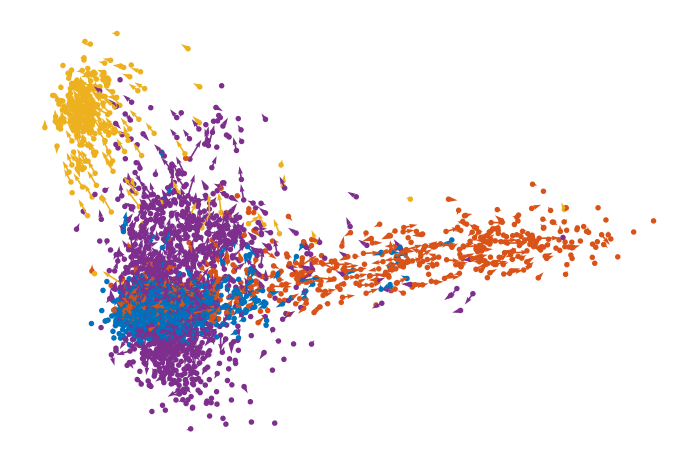

In [34]:
pa.visualize_velocity_projection(vlm, 'delta_P_in_S_pca')

Visualize cluster-specific velocities.

In [35]:
# pa.cluster_specific_plot(vlm, 'delta_S_in_S_pca',draw_cells=True)

In [36]:
# pa.cluster_specific_plot(vlm, 'delta_P_in_S_pca',draw_cells=True)

In [37]:
pa.initialize_grid_embedding(vlm)
uv_multiplier=2
pa.calculate_grid_arrows(vlm,'delta_S_in_S_pca', '_rna', min_mass=4,uv_multiplier=uv_multiplier)
pa.calculate_grid_arrows(vlm,'delta_P_in_S_pca', '_prot', min_mass=4,uv_multiplier=uv_multiplier)


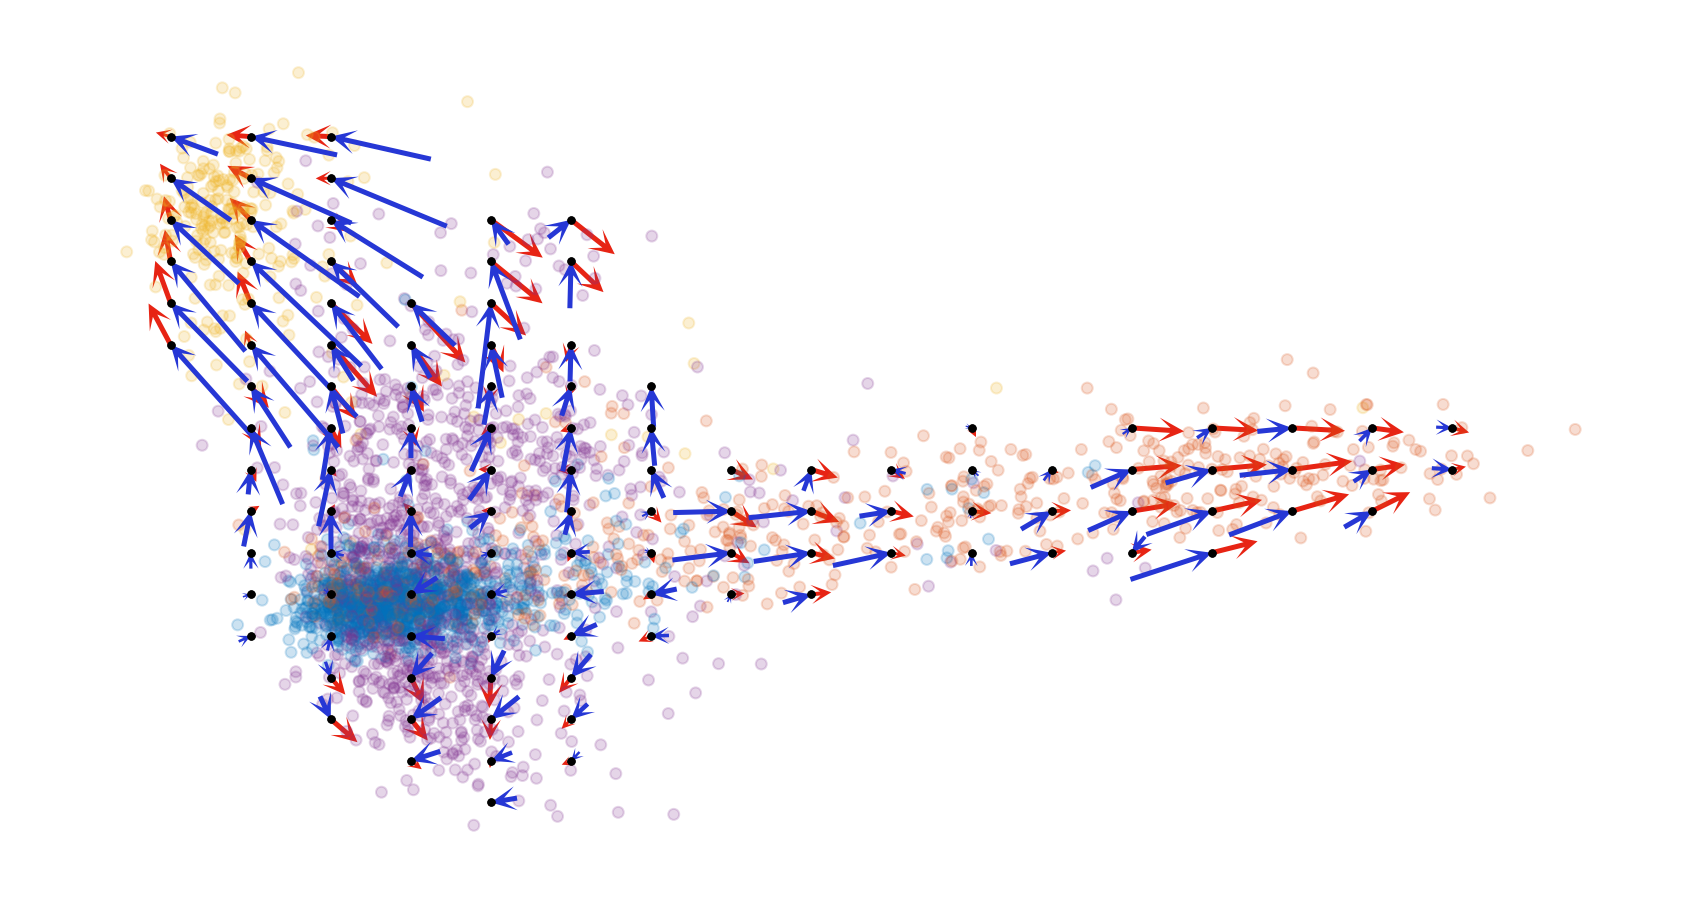

In [38]:
r_rnav = [231/255,36/255,20/255]
b_protv = [38/255,55/255,213/255]
plt.figure(figsize=(15,8))
pa.plot_grid_arrows(vlm,'UV_rna',plot_cells=False, arr_col=r_rnav)
pa.plot_grid_arrows(vlm,'UV_prot',plot_cells=True, arr_col=b_protv, color_cells_by_cluster=True, pivot='tip',cell_alpha=0.2)


In [39]:
# plt.figure(figsize=(15,15))
# pa.plot_bezier(vlm, plot_cells=True, color_cells_by_cluster=True,cell_alpha=0.2)

Calculate t-SNE embedding based on normalized spliced counts. Perform analysis in t-SNE space. 

In [40]:
n_pcs_S = 25
n_pcs_P = 10
pa.fit_pcs(vlm,'S_norm','pcs_S',n_pcs_S)
pa.fit_pcs(vlm,'P_norm','pcs_P',n_pcs_P)

In [41]:
from louvain_clustering import *
n_clusters = 4
rna_label = louvain_exact_K(getattr(vlm,'pcs_S')[:, :10], n_clusters)
print("ARI score bw RNA and ADT: ", adjusted_rand_score(rna_label, cluster_ID))

/home/vanhoan310/miniconda3/envs/tsne/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


ARI score bw RNA and ADT:  0.763955640423018


In [42]:
from sklearn.manifold import TSNE, JTSNE
def fit_jointTSNE(vlm, pc_space_name1, pc_space_name2, n_pcs1, n_pcs2, ts_name, init = 'pca', seed=None):
    #bh_tsne = TSNE(random_state=seed)
    data = {'X1': getattr(vlm,pc_space_name1)[:, :n_pcs1], 'X2': getattr(vlm,pc_space_name2)[:, :n_pcs2]}
    bh_tsne = JTSNE(init = init, random_state = seed).fit_transform(X = data, method = 'auto', _lambda = 3)
    setattr(vlm,ts_name,bh_tsne)
    

In [43]:
fit_jointTSNE(vlm, 'pcs_P','pcs_S', n_pcs_P,  n_pcs_S,'tsne')

In [44]:
pa.identify_embedding_knn(vlm,'tsne',[0,1])

In [45]:
pa.calculate_embedding_delta(vlm,'Sx','delta_S','delta_S_in_S_tsne','rna_velo_gene_ind')

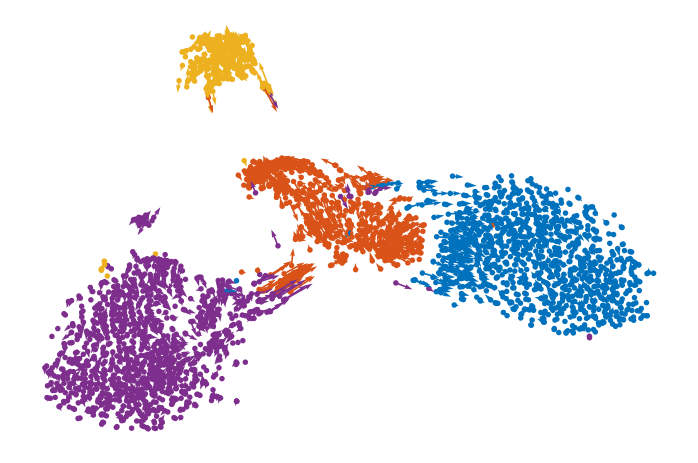

In [46]:
pa.visualize_velocity_projection(vlm, 'delta_S_in_S_tsne')

In [47]:
pa.calculate_embedding_delta(vlm,'Px','delta_P','delta_P_in_S_tsne','prot_velo_prot_ind')

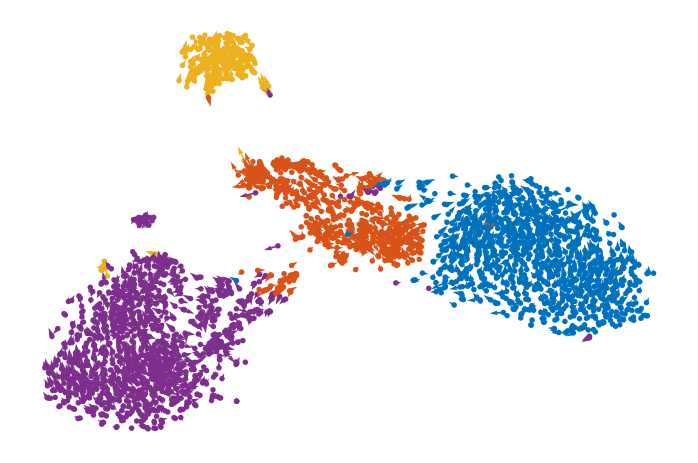

In [48]:
pa.visualize_velocity_projection(vlm, 'delta_P_in_S_tsne')

Visualize cluster-specific velocities.


In [49]:
# pa.cluster_specific_plot(vlm, 'delta_S_in_S_tsne',draw_cells=True)
# plt.savefig("fig/reap_rnav.svg")

In [50]:
# pa.cluster_specific_plot(vlm, 'delta_P_in_S_tsne',draw_cells=True)
# plt.savefig("fig/reap_protv.svg")

Prepare and perform grid embedding.

In [51]:
if hasattr(vlm,'mass_filter'):
    delattr(vlm,'mass_filter')
pa.initialize_grid_embedding(vlm, n_neighbors=50)
uv_multiplier=2
pa.calculate_grid_arrows(vlm,'delta_S_in_S_tsne', '_rna', min_mass=0.5,uv_multiplier=uv_multiplier+2)
pa.calculate_grid_arrows(vlm,'delta_P_in_S_tsne', '_prot', min_mass=0.5,uv_multiplier=uv_multiplier)

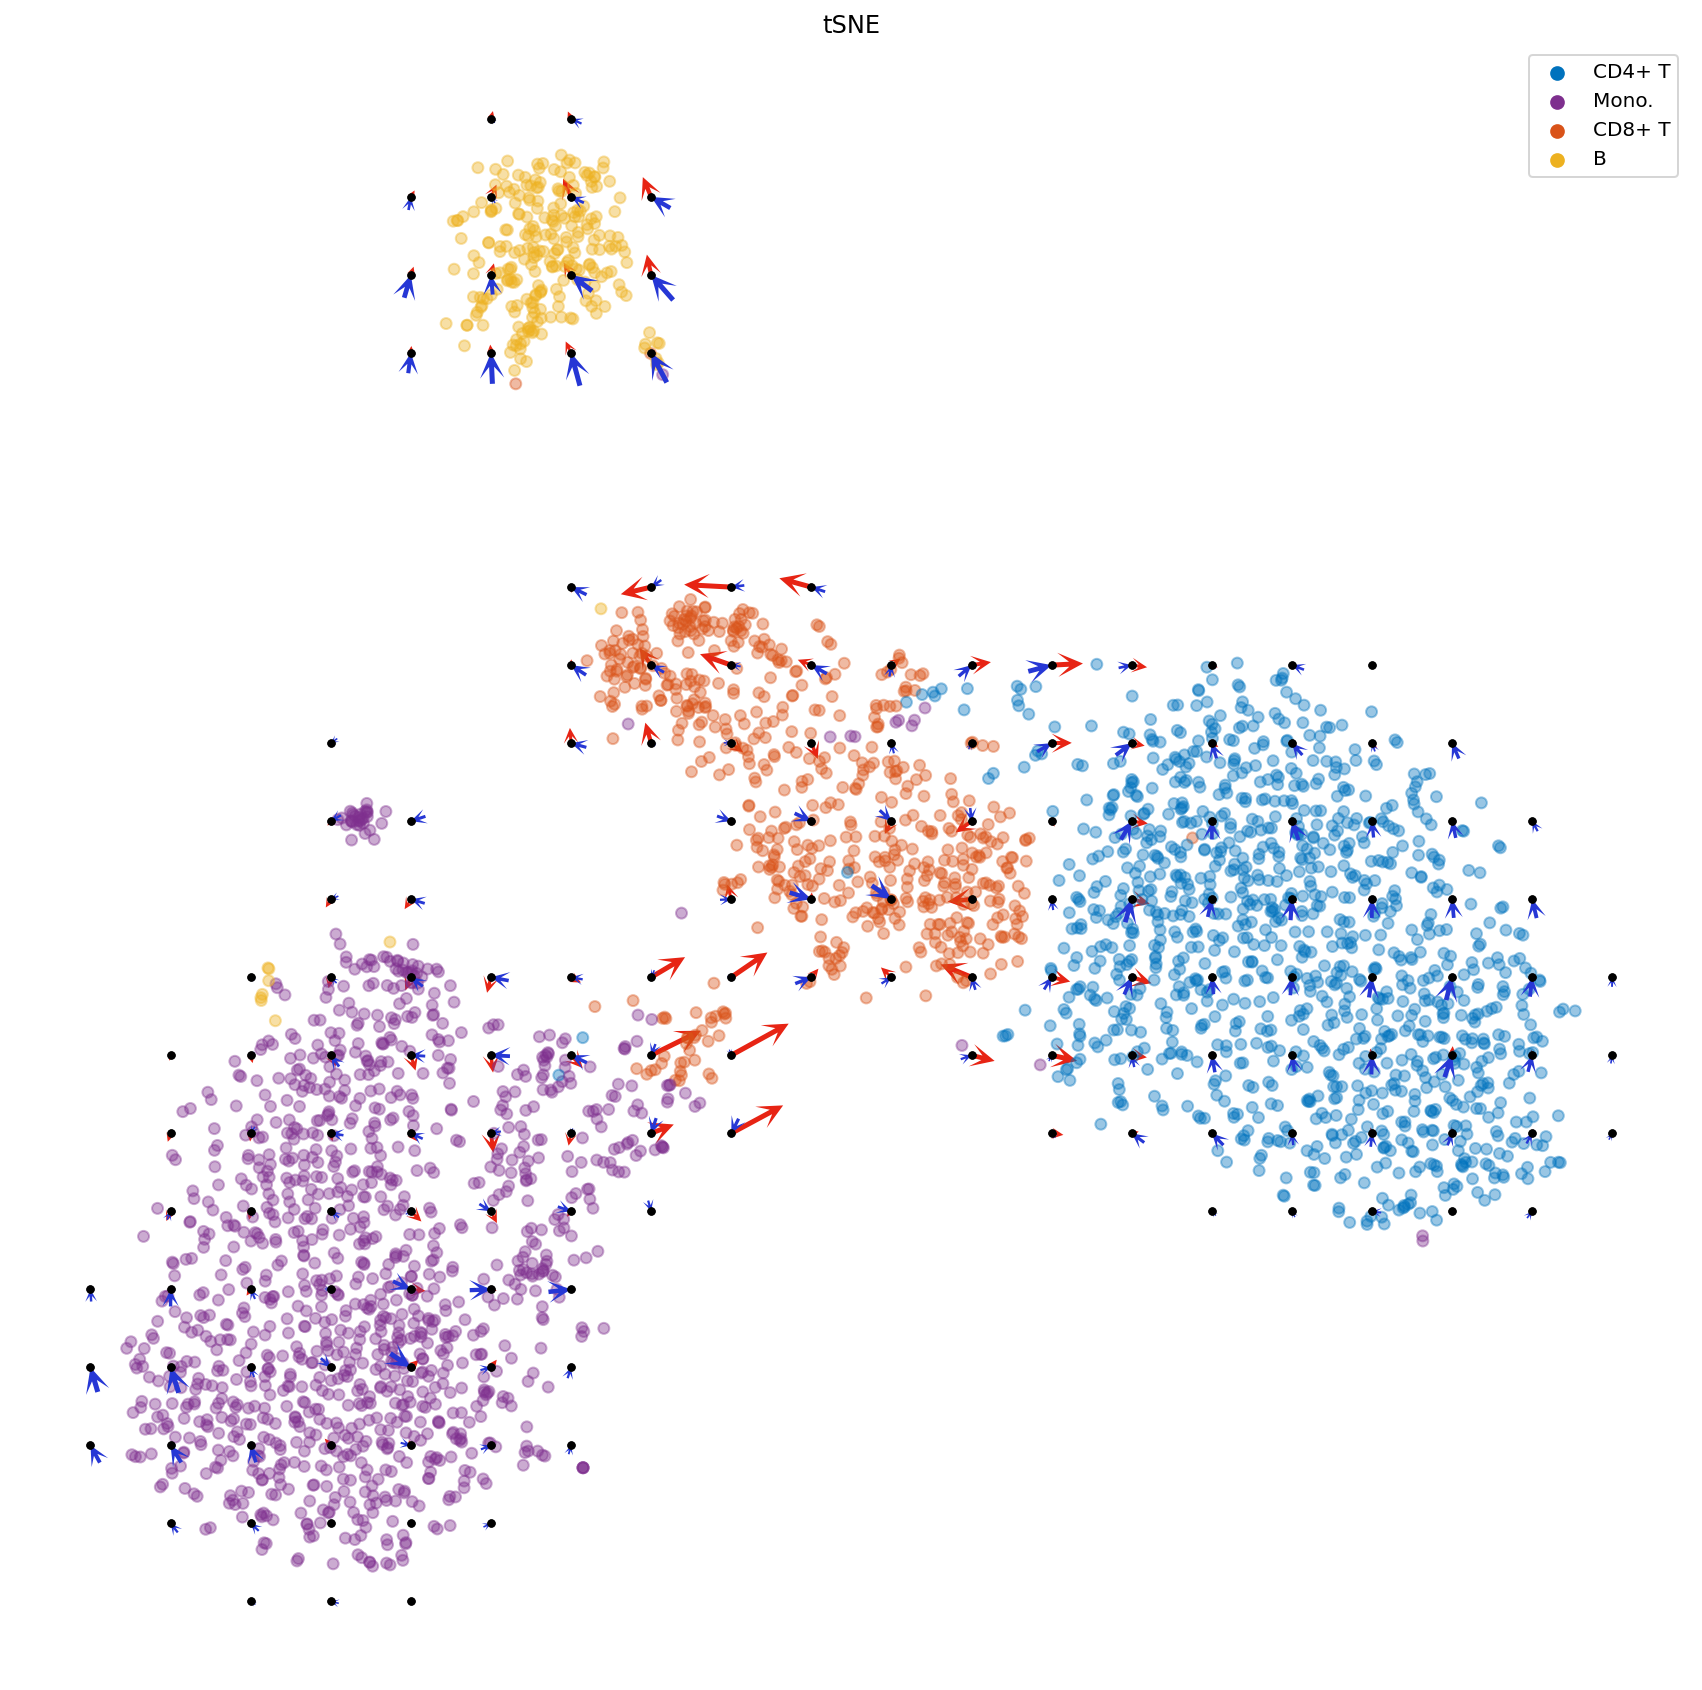

In [52]:
r_rnav = [231/255,36/255,20/255]
b_protv = [38/255,55/255,213/255]
plt.figure(figsize=(15,15))
pa.plot_grid_arrows(vlm,'UV_rna',plot_cells=False, arr_col=r_rnav,arr_scale=1)
pa.plot_grid_arrows(vlm,'UV_prot',plot_cells=True, arr_col=b_protv, color_cells_by_cluster=True, 
                    pivot='tip',cell_alpha=0.4,arr_scale=1,write_labels=True)
# plt.savefig("fig/reap_comb.svg")
plt.title("tSNE")
plt.savefig("/data/hoan/plots/reap_tsne.pdf")

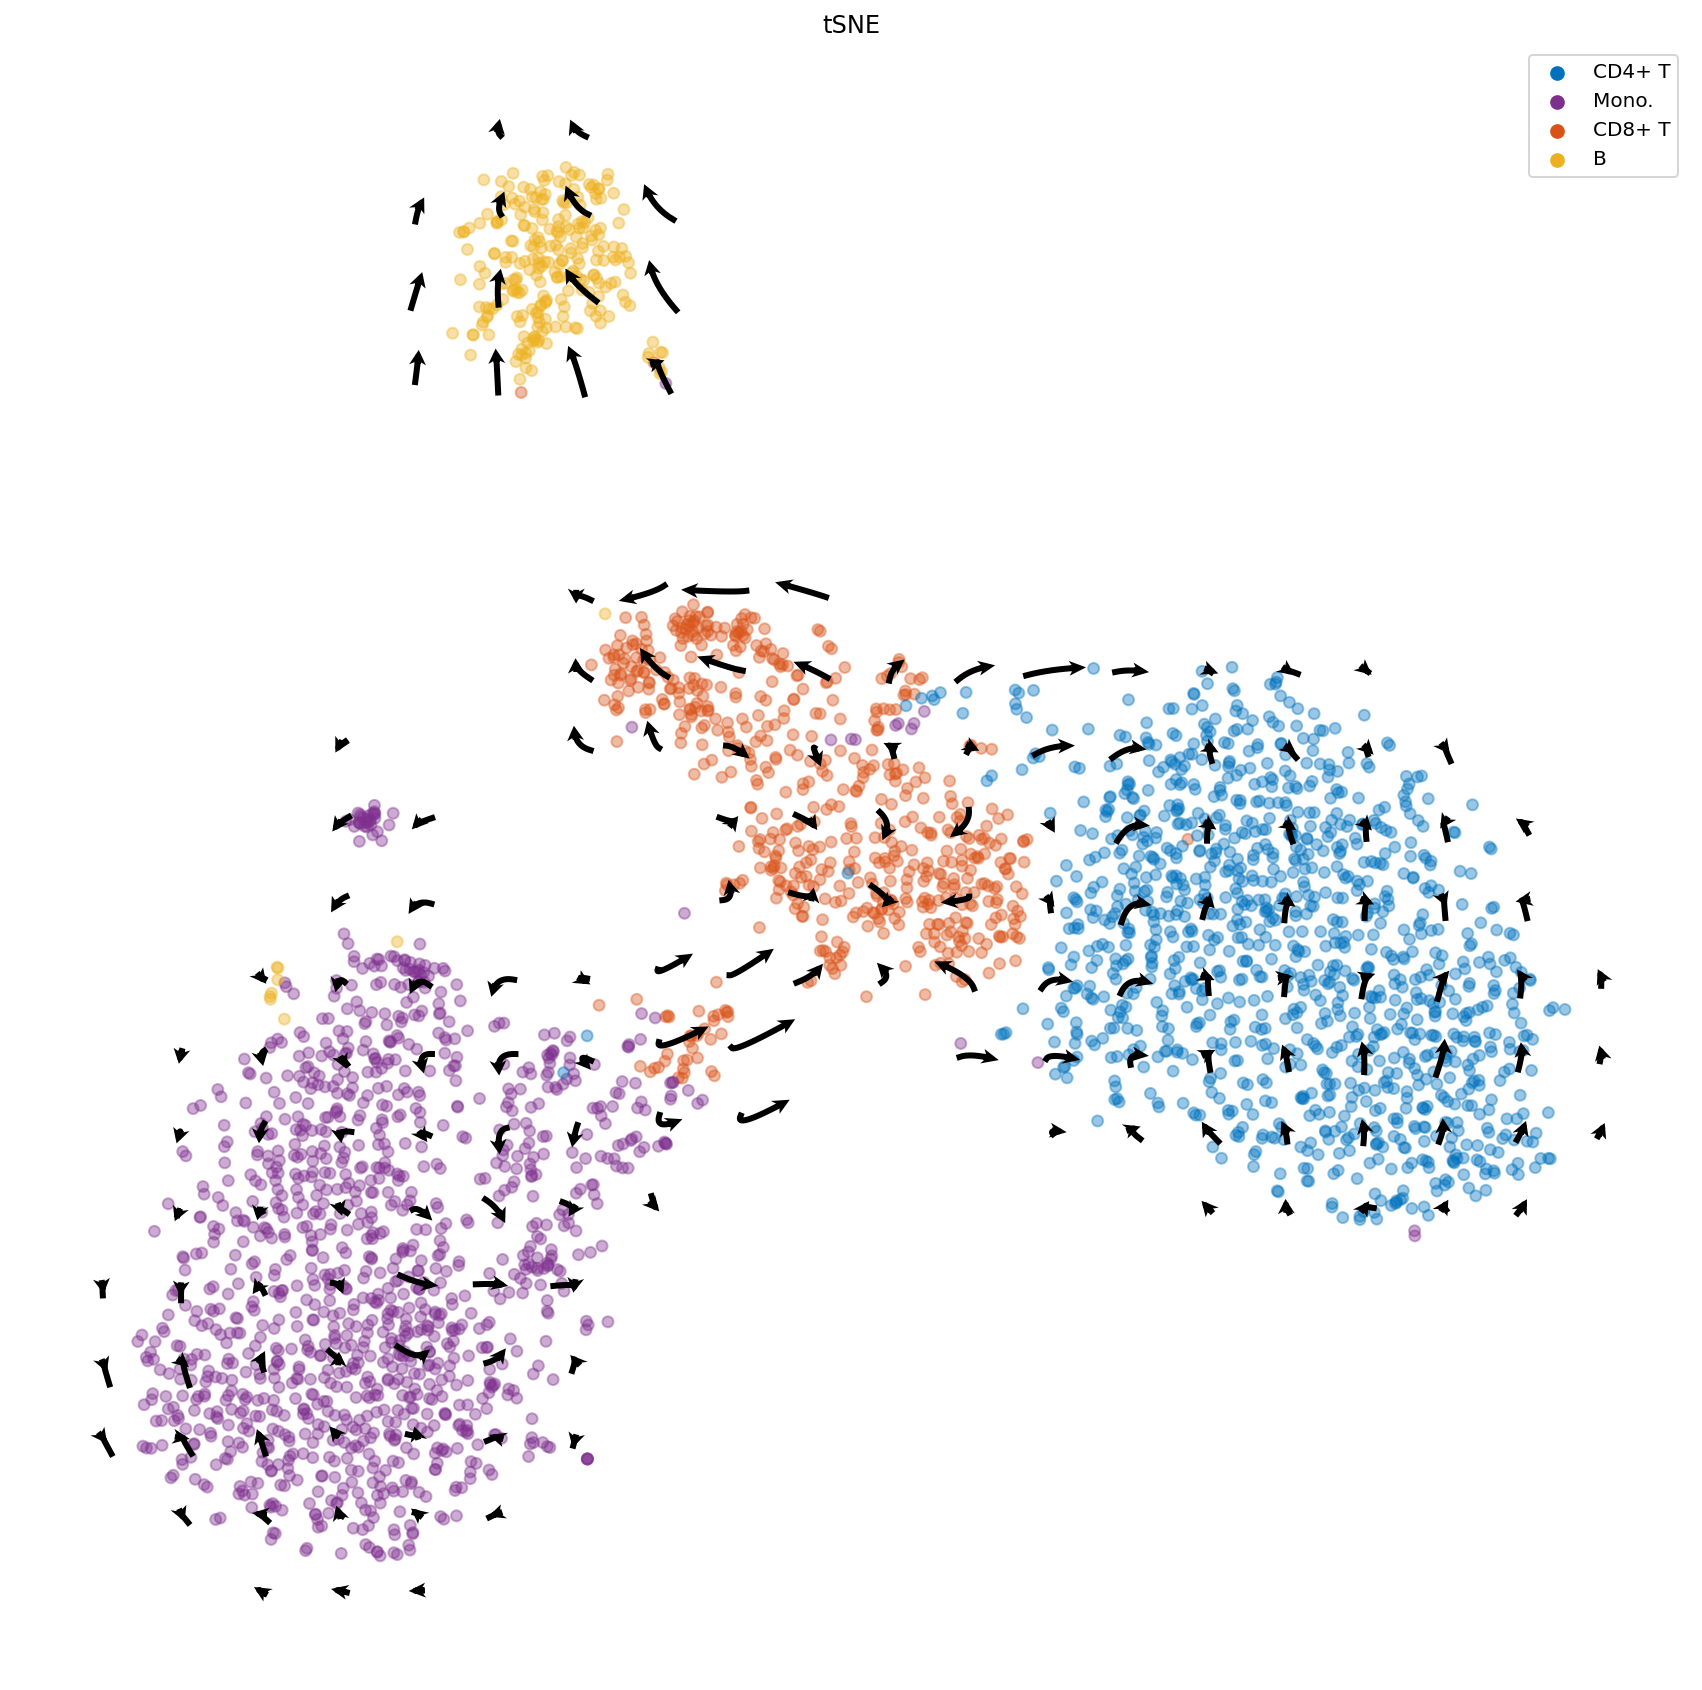

In [53]:
plt.figure(figsize=(15,15))
pa.plot_bezier(vlm, plot_cells=True, color_cells_by_cluster=True, arr_len_scal=0.6,cell_alpha=0.4,write_labels=True)
plt.title("tSNE")
plt.savefig("/data/hoan/plots/reap_bez_tsne.pdf")

In [54]:
from louvain_clustering import *
n_clusters = 4
rna_label = louvain_exact_K(getattr(vlm,'pcs_S')[:, :10], n_clusters)
print("ARI score bw RNA and ADT: ", adjusted_rand_score(rna_label, cluster_ID))

ARI score bw RNA and ADT:  0.763955640423018
